*JSC270, Winter 2020 - Prof. Chevalier*

# <center>  Assignment 2 - Yelp  </center>
<center> Karl Hendrik Nurmeots, February 19, 2020 </center>



***

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import seaborn as sns
import simplejson as json
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
import re

In [2]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [15,7]

# Introduction

[Yelp](https://www.yelp.com/) is a business directory service and crowd-sourced review forum.

# The Yelp Dataset

For this report we will be using the [Yelp dataset](https://www.yelp.com/dataset/challenge). **For this report to compile, you must download the data from the website and place it in extracted form in the 'data' directory!**. This requires you to provide your email and name.

Per the [Yelp dataset license](https://s3-media1.fl.yelpcdn.com/assets/srv0/engineering_pages/06cb5ad91db8/assets/vendor/yelp-dataset-agreement.pdf), one is allowed to create a report of the data such as this one only for academic purposes. Any sort of disclosure or sharing of the dataset itself is strictly prohibited - this is a private dataset. Any use of the dataset must not disparage Yelp.

A more detailed overview of the dataset can be found on the [dataset documentation page](https://www.yelp.com/dataset/documentation/main). Due to the comprehensive extent of the dataset we will only provide a short insight into what the dataset contains. The dataset consists of 6 JSON files: 

`business.json` contains information about each establishment in the dataset such as the business' name, ID, location (address and coordinates), Yelp rating and review count, attributes (e.g. if the business provides a takeout service), category, and opening hours.

`review.json` contains information about each review, namely the author ID, business reviewed ID, rating, date, full review text, and the number of "useful", "funny" and "cool" votes the review has recieved. Author ID maps to the corresponding user in user.json, and business ID maps to the business in business.json.

`user.json` contains information about users' IDs, first names, their friends' user IDs, and info about the feedback they have recieved on their reviews (e.g. total "useful" votes).

`checkin.json` contains each business' ID and a collection of timestamps when users have checked in at that business. Again, the business ID maps to business.json.

`tip.json` contains information about short tips that users have posted, and is structured similarly to review.json. Tips are essentially very short reviews, but do not give a numeric rating about the business. Instead of tracking the number of different votes, the number of "compliments" the tip has recieved is tracked.

`photo.json` contains metadata about photos users have posted: the business' ID the picture is about, the author's user ID, the picture's caption and label (e.g. "food"). 

For this analysis, we will only use `business.json` and `review.json`.

In [3]:
def json_to_dataframe(file: str, nrows = 0) -> pd.DataFrame:
    """Returns a Pandas dataframe from the JSON file located at <file>."""
    with open(file, 'r', encoding="utf8") as f:
        if nrows == 0:
            content = f.readlines()
        else:
            content = []
            for i in range(nrows):
                content.append(f.readline())
        
    return pd.DataFrame([json.loads(row) for row in content])

In [4]:
# Reading in the 2 JSON files
business = json_to_dataframe("data/business.json", 500)
review = json_to_dataframe("data/review.json", 500)

In [5]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


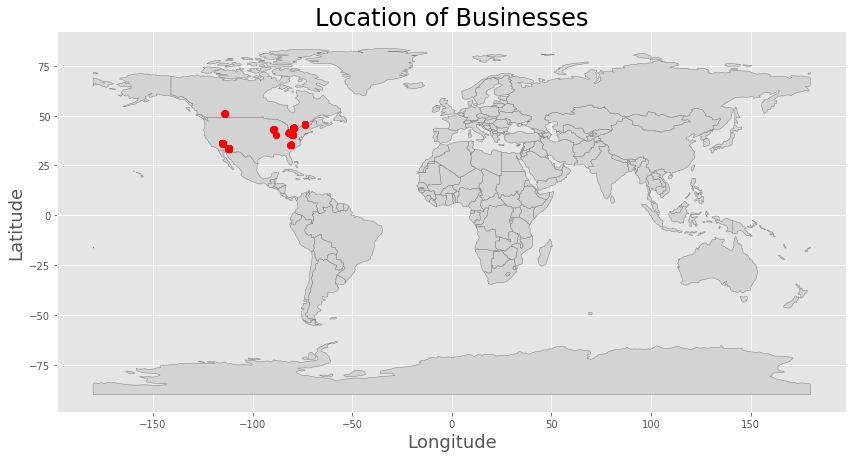

In [11]:
gdf = gpd.GeoDataFrame(
    business, geometry=gpd.points_from_xy(business.longitude, business.latitude))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='lightgrey', edgecolor='grey')

gdf.plot(ax=ax, color='red')

plt.title("Location of Businesses", fontsize=24)
plt.xlabel("Longitude", fontsize=18)
plt.ylabel("Latitude", fontsize=18)
plt.show()

As we can see, we only have US and Canada businesses. Different zip code formats, so we can distinguish country.

In [8]:
def get_country(row: pd.Series) -> str:
    """Given a Pandas series representing a row about a business, returns the country
       the business is located in.
       
       Note that postal codes in Canada always contain letters, while US postal codes do not."""
    
    if re.search('[a-zA-Z]', row.postal_code) is None:
        return "USA"
    return "Canada"

business['country'] = business.apply(lambda row: get_country(row), axis=1)

Let's first see how the businesses in the dataset distribute in terms of the country they are located in:

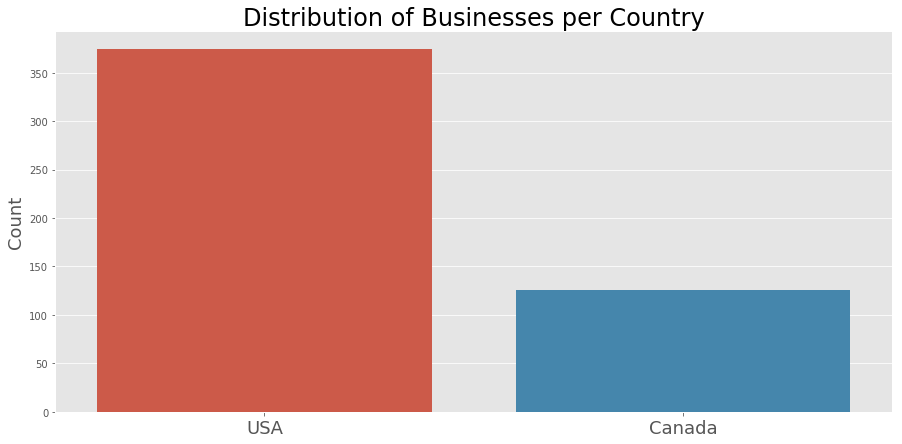

In [16]:
sns.countplot(x=business.country)

plt.title("Distribution of Businesses per Country", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=18)
plt.show()

We can see that most businesses are located in the US.

When we take a look at the different cities present in the dataset, we will realise that there are many inconsistencies in the city names: for example, both "Montréal" and "Montreal" show up.

We would like to fix this issue, so we will use FuzzyWuzzy, a fuzzy string matching package. Our businesses dataset is very large, and this type of string fixing is very demanding, so we will have to compromise: we will only try to fix the names of the largest 100 cities in the US and Canada (separately). A quick glimpse into the data tells us that most businesses are located in these cities, so it is also more likely that there are inconsistencies in the city names for these businesses.

More precisely, we will look at the biggest cities by population based on Wikipedia: [Canada](https://en.wikipedia.org/wiki/List_of_the_100_largest_municipalities_in_Canada_by_population) and [USA](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population).

In [53]:
url_ca = 'https://en.wikipedia.org/wiki/List_of_the_100_largest_municipalities_in_Canada_by_population'
url_usa = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'

canada = pd.read_html(url_ca, attrs = {"class":"wikitable sortable"})[0]
canada_cities = canada.Municipality.values

usa = pd.read_html(url_usa, attrs = {"class":"wikitable sortable"})[0]
usa_cities = usa.City.values[:100]

# Reading in the USA cities data sometimes adds weird tags to the city names, so we will
# remove them.
for i in range(len(usa_cities)):
    usa_cities[i] = re.sub('\[.\]$', '', usa_cities[i])

array(['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix',
       'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose',
       'Austin', 'Jacksonville', 'Fort Worth', 'Columbus',
       'San Francisco', 'Charlotte', 'Indianapolis', 'Seattle', 'Denver',
       'Washington', 'Boston', 'El Paso', 'Detroit', 'Nashville',
       'Portland', 'Memphis', 'Oklahoma City', 'Las Vegas', 'Louisville',
       'Baltimore', 'Milwaukee', 'Albuquerque', 'Tucson', 'Fresno',
       'Mesa', 'Sacramento', 'Atlanta', 'Kansas City', 'Colorado Springs',
       'Miami', 'Raleigh', 'Omaha', 'Long Beach', 'Virginia Beach',
       'Oakland', 'Minneapolis', 'Tulsa', 'Arlington', 'Tampa',
       'New Orleans', 'Wichita', 'Cleveland', 'Bakersfield', 'Aurora',
       'Anaheim', 'Honolulu', 'Santa Ana', 'Riverside', 'Corpus Christi',
       'Lexington', 'Stockton', 'Henderson', 'Saint Paul', 'St. Louis',
       'Cincinnati', 'Pittsburgh', 'Greensboro', 'Anchorage', 'Plano',
       'Lincoln', 'Orlan